# My-Fashion-MNIST-Experiments

In this notebook, I will design my own CNN architecture for classifying the Fashion-MNIST dataset, and will write functions such that I can experiment with different hyperparameters and loss functions/optimizers. LESHGOOOO

Note that just for loading the data in, I will use pre-existing code from [this tutorial](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html), which I also used in my `fashion-mnist.ipynb` notebook.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F 

from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [3]:
train_data = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [5]:
# experiment - play with the number of batches I want
# default is 4
batch_size = 5

In [6]:
# Create data loaders for our datasets; shuffle for training, not for test
training_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [7]:
# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(train_data)))
print('Testing set has {} instances'.format(len(test_data)))

Training set has 60000 instances
Testing set has 10000 instances


Sneaker  Sandal  Coat  Coat  Pullover


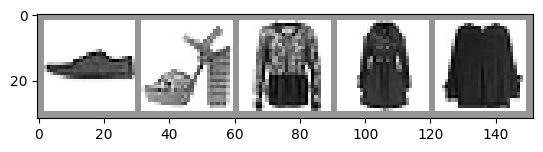

In [8]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(batch_size)))

In [9]:
len(train_data)

60000

In [10]:
train_sample, train_label = train_data[0]
train_sample.shape

torch.Size([1, 28, 28])

## Defining Model Architecture

Let's go for 3 convolutions, 4 fully-connected layers, options for activation (ReLU, sigmoid, tanh), and options for pooling (max, avg). This also gives me a great chance to 1. test out different model architectures, and 2. to test out the limits of my machine (MacBook Pro M3).

In [11]:
def cnn_dims(input_matrix_size, kernel_size):
    output_size_n = input_matrix_size - kernel_size + 1
    print(f'Input matrix size: {input_matrix_size}x{input_matrix_size}')
    print(f'Kernel size: {kernel_size}x{kernel_size}')
    print(f'Therefore output convolved matrix size: {output_size_n}x{output_size_n}')
    return output_size_n

def pooling_dims(input_matrix_size, kernel_size, stride):
    output_size_n = int(np.floor((input_matrix_size - kernel_size) / stride) + 1)
    print(f'Input matrix size: {input_matrix_size}x{input_matrix_size}')
    print(f'Kernel size: {kernel_size}x{kernel_size} + stride: {stride}')
    print(f'Therefore output pooled matrix size: {output_size_n}x{output_size_n}')
    return output_size_n

In [12]:
class MyFashionClassifier(nn.Module):

    def __init__(self, my_params):
        super(MyFashionClassifier, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=my_params['conv1_out_channels'],
            kernel_size=my_params['conv_kernel_size'],
            stride=my_params['conv_stride']
        )
        self.conv2 = nn.Conv2d(
            in_channels=my_params['conv1_out_channels'],
            out_channels=my_params['conv2_out_channels'],
            kernel_size=my_params['conv_kernel_size'],
            stride=my_params['conv_stride']
        )
        self.conv3 = nn.Conv2d(
            in_channels=my_params['conv2_out_channels'],
            out_channels=my_params['conv3_out_channels'],
            kernel_size=my_params['conv_kernel_size'],
            stride=my_params['conv_stride']
        )
        
        self.pool_type = my_params['pool_type']
        if self.pool_type == 'max':
            self.pool = nn.MaxPool2d(kernel_size=my_params['pool_kernel_size'], stride=my_params['pool_stride'])
        elif self.pool_type == 'avg':
            self.pool = nn.AvgPool2d(kernel_size=my_params['pool_kernel_size'], stride=my_params['pool_stride'])

        self.activation_type = my_params['activation_type']

        self.fc1 = nn.Linear(
            in_features=my_params['fc1_in_features'],
            out_features=my_params['fc1_out_features']
        )
        self.fc2 = nn.Linear(
            in_features=my_params['fc1_out_features'],
            out_features=my_params['fc2_out_features']
        )
        self.fc3 = nn.Linear(
            in_features=my_params['fc2_out_features'],
            out_features=my_params['fc3_out_features']
        )
        self.fc4 = nn.Linear(
            in_features=my_params['fc3_out_features'],
            out_features=10
        )

    def forward(self, x):
        # if self.pool_type == 'max':
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, 128 * 2 * 2)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### Instantiating Parameter Dictionary

First we start by getting an idea of how our dimensions look like between layers. We will then use this to fill our parameters dict.

In [13]:
conv_kernel_size = 2
pool_kernel_size = 2
pool_stride = 2

print("First convolutional block")
conv1_output = cnn_dims(28, conv_kernel_size)
print("")
pool1_output = pooling_dims(conv1_output, pool_kernel_size, pool_stride)
print("------")
print("Second convolutional block")
conv2_output = cnn_dims(pool1_output, conv_kernel_size)
print("")
pool2_output = pooling_dims(conv2_output, pool_kernel_size, pool_stride)
print("------")
print("Third convolutional block")
conv3_output = cnn_dims(pool2_output, conv_kernel_size)
print("")
pool3_output = pooling_dims(conv3_output, pool_kernel_size, pool_stride)

First convolutional block
Input matrix size: 28x28
Kernel size: 2x2
Therefore output convolved matrix size: 27x27

Input matrix size: 27x27
Kernel size: 2x2 + stride: 2
Therefore output pooled matrix size: 13x13
------
Second convolutional block
Input matrix size: 13x13
Kernel size: 2x2
Therefore output convolved matrix size: 12x12

Input matrix size: 12x12
Kernel size: 2x2 + stride: 2
Therefore output pooled matrix size: 6x6
------
Third convolutional block
Input matrix size: 6x6
Kernel size: 2x2
Therefore output convolved matrix size: 5x5

Input matrix size: 5x5
Kernel size: 2x2 + stride: 2
Therefore output pooled matrix size: 2x2


In [14]:
my_params = {
    # number of output channels for each convolution
    # good rule of thumb is to double every time
    'conv1_out_channels':32,
    'conv2_out_channels':64,
    'conv3_out_channels':128,
    # number of fully-connected layers - max 4
    'fc1_in_features':128 * 2 * 2, # x * y * y, where x=conv3_out_channels and y=dim(conv3_out_channels)
    'fc1_out_features':256, # perhaps we can halve every time now?
    'fc2_out_features':128,
    'fc3_out_features':64,
    # kernel size - same for all convolutions and for all poolings
    'conv_kernel_size':2,
    'pool_kernel_size':2,
    # stride - same for all convolutions and for all poolings
    'conv_stride':1,
    'pool_stride':2,
    # desired pooling type - either of {'max', 'avg'}
    'pool_type': 'avg',
    # desired activation - either of {'relu', 'sigmoid', 'tanh'}
    'activation_type': 'relu',
    # optimizer - either of {'sgd', 'adam'}
    'optimizer':'sgd'
}

# instantiating the model
fashion_classifier_model = MyFashionClassifier(my_params)

### Defining Loss Function + Optimizer

In [15]:
loss_fn = torch.nn.CrossEntropyLoss() 

In [16]:
def choose_optimizer(model, optimizer_choice, learning_rate, momentum=None):
    # function to choose optimizer
    if optimizer_choice == 'sgd': 
        optimizer = torch.optim.SGD(
            params=model.parameters(), 
            lr=learning_rate, 
            momentum=momentum
            ) 
    elif optimizer_choice=='adam': 
        optimizer = torch.optim.Adam(model.parameters(), learning_rate)
    return optimizer

my_optimizer = choose_optimizer(
    model=fashion_classifier_model, 
    optimizer_choice=my_params['optimizer'], 
    learning_rate=0.001,
    momentum=0.9
    )

In [17]:
def plot_loss_accuracy_curves(losses, accuracies, epoch_num):
    # plotting loss vs epoch
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title(f'Epoch {epoch_num}: Loss Curve')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    # plotting accuracy vs epoch
    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.title(f'Epoch {epoch_num}: Accuracy Curve (avg={np.round(np.mean(accuracies),2)}%)')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy (%)')
    plt.show()

### Model Training

In [18]:
def train_model(
        model, params, optimizer, loss_fn, training_loader, num_epochs=10
    ):
    
    losses = []
    accuracies = []

    # iterating over number of epochs
    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_correct = 0
        epoch_samples = 0

        for i, (inputs, labels) in enumerate(training_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            
            predicted = torch.argmax(outputs, 1)
            epoch_correct += (predicted == labels).sum().item()
            epoch_samples += labels.size(0)

            if (i + 1) % 1000 == 0:
                batch_loss = epoch_loss / (i + 1)
                losses.append(batch_loss)

                accuracy = 100 * epoch_correct / epoch_samples
                accuracies.append(accuracy)

                print(f'Epoch [{epoch+1}/{num_epochs}], Batch {i+1}, Loss: {batch_loss:.4f}, Accuracy: {accuracy:.4f}')

        # End of epoch logging
        epoch_loss_avg = epoch_loss / len(training_loader)
        losses.append(epoch_loss_avg)
        accuracy = 100 * epoch_correct / epoch_samples
        accuracies.append(accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss_avg:.4f}, Accuracy: {accuracy:.4f}')
        
        plot_loss_accuracy_curves(losses, accuracies, epoch+1)

    return losses, accuracies


Epoch [1/5], Batch 1000, Loss: 2.3036, Accuracy: 10.3800
Epoch [1/5], Batch 2000, Loss: 2.3028, Accuracy: 9.9500
Epoch [1/5], Batch 3000, Loss: 2.3008, Accuracy: 11.6733
Epoch [1/5], Batch 4000, Loss: 2.2708, Accuracy: 14.2050
Epoch [1/5], Batch 5000, Loss: 2.0692, Accuracy: 21.3320
Epoch [1/5], Batch 6000, Loss: 1.8909, Accuracy: 28.0967
Epoch [1/5], Batch 7000, Loss: 1.7503, Accuracy: 33.4457
Epoch [1/5], Batch 8000, Loss: 1.6369, Accuracy: 37.7750
Epoch [1/5], Batch 9000, Loss: 1.5442, Accuracy: 41.3222
Epoch [1/5], Batch 10000, Loss: 1.4674, Accuracy: 44.2380
Epoch [1/5], Batch 11000, Loss: 1.4001, Accuracy: 46.9000
Epoch [1/5], Batch 12000, Loss: 1.3443, Accuracy: 48.9983
Epoch [1/5], Loss: 1.3443, Accuracy: 48.9983


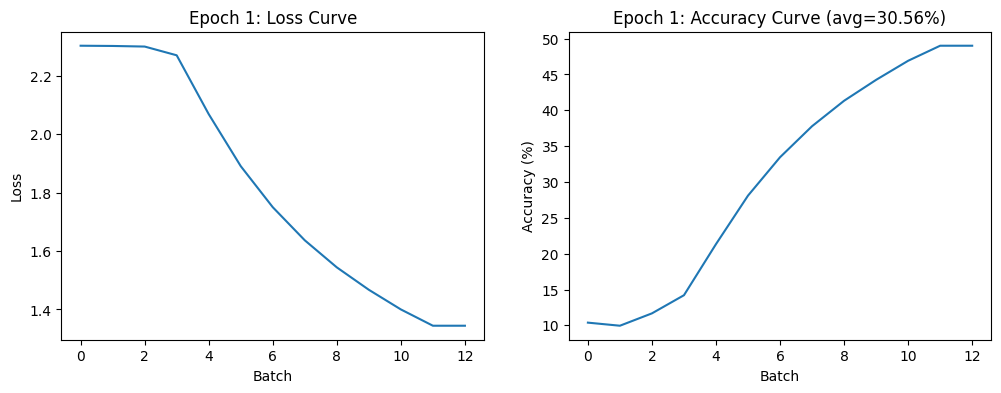

Epoch [2/5], Batch 1000, Loss: 0.6915, Accuracy: 72.9200
Epoch [2/5], Batch 2000, Loss: 0.6906, Accuracy: 73.5400
Epoch [2/5], Batch 3000, Loss: 0.6785, Accuracy: 74.1400
Epoch [2/5], Batch 4000, Loss: 0.6725, Accuracy: 74.5000
Epoch [2/5], Batch 5000, Loss: 0.6680, Accuracy: 74.6040
Epoch [2/5], Batch 6000, Loss: 0.6639, Accuracy: 74.7500
Epoch [2/5], Batch 7000, Loss: 0.6564, Accuracy: 75.0514
Epoch [2/5], Batch 8000, Loss: 0.6526, Accuracy: 75.1650
Epoch [2/5], Batch 9000, Loss: 0.6490, Accuracy: 75.3200
Epoch [2/5], Batch 10000, Loss: 0.6461, Accuracy: 75.4480
Epoch [2/5], Batch 11000, Loss: 0.6432, Accuracy: 75.5636
Epoch [2/5], Batch 12000, Loss: 0.6392, Accuracy: 75.6933
Epoch [2/5], Loss: 0.6392, Accuracy: 75.6933


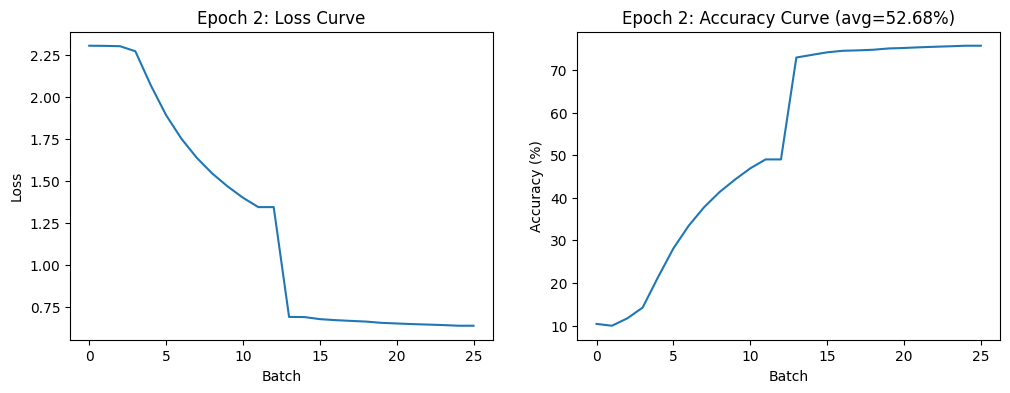

Epoch [3/5], Batch 1000, Loss: 0.5870, Accuracy: 78.0800
Epoch [3/5], Batch 2000, Loss: 0.5903, Accuracy: 77.8900
Epoch [3/5], Batch 3000, Loss: 0.5781, Accuracy: 78.3600
Epoch [3/5], Batch 4000, Loss: 0.5721, Accuracy: 78.4350
Epoch [3/5], Batch 5000, Loss: 0.5724, Accuracy: 78.4480
Epoch [3/5], Batch 6000, Loss: 0.5709, Accuracy: 78.4233
Epoch [3/5], Batch 7000, Loss: 0.5687, Accuracy: 78.4800
Epoch [3/5], Batch 8000, Loss: 0.5659, Accuracy: 78.5550
Epoch [3/5], Batch 9000, Loss: 0.5649, Accuracy: 78.5889
Epoch [3/5], Batch 10000, Loss: 0.5629, Accuracy: 78.6860
Epoch [3/5], Batch 11000, Loss: 0.5603, Accuracy: 78.8309
Epoch [3/5], Batch 12000, Loss: 0.5558, Accuracy: 79.0000
Epoch [3/5], Loss: 0.5558, Accuracy: 79.0000


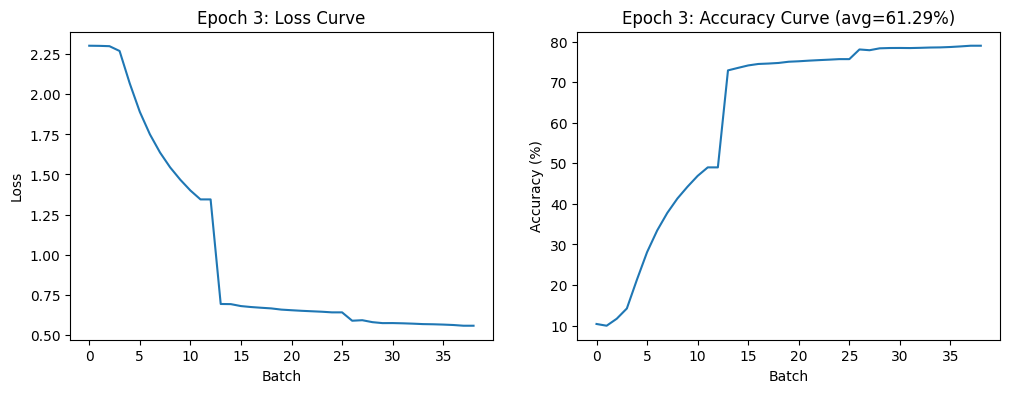

Epoch [4/5], Batch 1000, Loss: 0.5287, Accuracy: 80.0400
Epoch [4/5], Batch 2000, Loss: 0.5329, Accuracy: 79.8200
Epoch [4/5], Batch 3000, Loss: 0.5275, Accuracy: 79.9800
Epoch [4/5], Batch 4000, Loss: 0.5203, Accuracy: 80.3000
Epoch [4/5], Batch 5000, Loss: 0.5176, Accuracy: 80.4680
Epoch [4/5], Batch 6000, Loss: 0.5126, Accuracy: 80.6200
Epoch [4/5], Batch 7000, Loss: 0.5092, Accuracy: 80.7086
Epoch [4/5], Batch 8000, Loss: 0.5056, Accuracy: 80.8800
Epoch [4/5], Batch 9000, Loss: 0.5044, Accuracy: 80.9000
Epoch [4/5], Batch 10000, Loss: 0.5014, Accuracy: 81.0020
Epoch [4/5], Batch 11000, Loss: 0.4996, Accuracy: 81.1055
Epoch [4/5], Batch 12000, Loss: 0.4979, Accuracy: 81.2017
Epoch [4/5], Loss: 0.4979, Accuracy: 81.2017


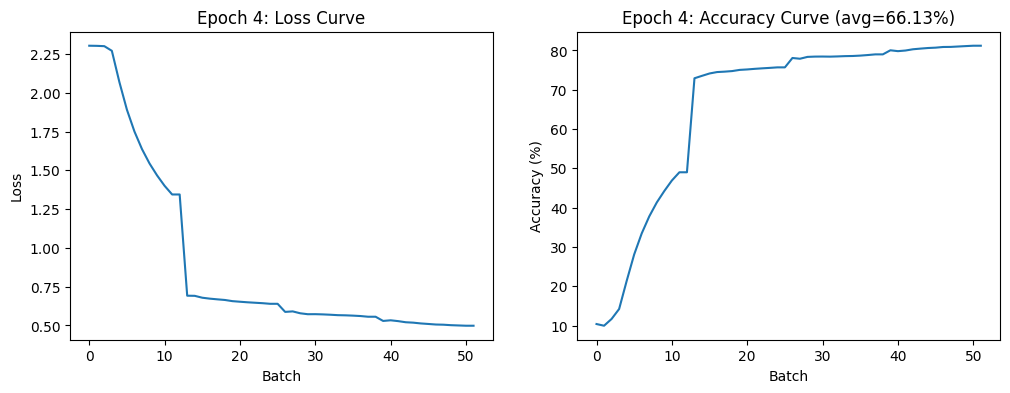

Epoch [5/5], Batch 1000, Loss: 0.4816, Accuracy: 81.6800
Epoch [5/5], Batch 2000, Loss: 0.4720, Accuracy: 82.0500
Epoch [5/5], Batch 3000, Loss: 0.4682, Accuracy: 82.3800
Epoch [5/5], Batch 4000, Loss: 0.4675, Accuracy: 82.4900
Epoch [5/5], Batch 5000, Loss: 0.4622, Accuracy: 82.5920
Epoch [5/5], Batch 6000, Loss: 0.4595, Accuracy: 82.6900
Epoch [5/5], Batch 7000, Loss: 0.4582, Accuracy: 82.7914
Epoch [5/5], Batch 8000, Loss: 0.4544, Accuracy: 82.9550
Epoch [5/5], Batch 9000, Loss: 0.4527, Accuracy: 82.9489
Epoch [5/5], Batch 10000, Loss: 0.4491, Accuracy: 83.0780
Epoch [5/5], Batch 11000, Loss: 0.4448, Accuracy: 83.2636
Epoch [5/5], Batch 12000, Loss: 0.4426, Accuracy: 83.3467
Epoch [5/5], Loss: 0.4426, Accuracy: 83.3467


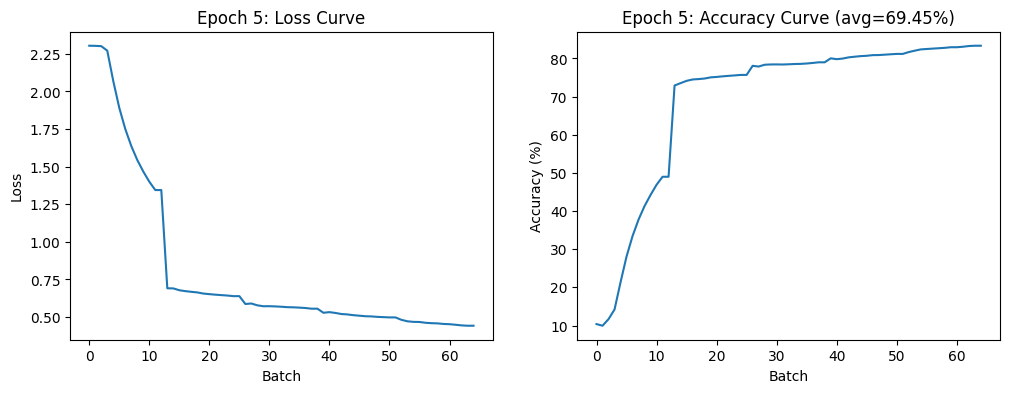

In [19]:
losses, accuracies = train_model(
    model=fashion_classifier_model, 
    params=my_params, 
    optimizer=my_optimizer, 
    loss_fn=loss_fn, 
    training_loader=training_loader,
    num_epochs=5
    )